In [1]:
import os
os.environ["MAIN_DIR"] = ""

In [2]:
from rdkit import Chem
import pickle
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
import tqdm
import json
import numpy as np
import itertools
from tabulate import tabulate

from action_utils import *

In [3]:
main_df = pd.read_csv("datasets/my_uspto/supervised_zinc_gin/dataset.csv", index_col=0)

In [4]:
N = 40000

# take N samples of it
np.random.seed(42)
print(main_df.shape)
elements_to_fetch = np.random.randint(0, main_df.shape[0], size=(N,))
main_df = main_df.iloc[elements_to_fetch]
print(main_df.shape)

(3976954, 10)
(40000, 10)


In [5]:
# Add samples for 2 step prediction
main_df_copy = main_df.copy()
main_df2 = pd.DataFrame(columns=main_df.columns)
index = []

for i in tqdm.tqdm(range(main_df.shape[0])):
    smile = main_df.iloc[i]["product"]
    mol = Chem.MolFromSmiles(smile)
    actions = get_applicable_actions(mol)
    if actions.shape[0] == 0:
        continue
    
    # Apply a random action
    rand_idx = np.random.randint(0, actions.shape[0])
    product = apply_action(mol, *actions.iloc[rand_idx])
    
    # Add it to main_df2
    main_df2.loc[main_df2.shape[0], :] = [smile] + actions.iloc[rand_idx].tolist() + [Chem.MolToSmiles(product)]
    
    # Update index
    index.append(actions.iloc[rand_idx].name)
    
    # Update original entry to make it 2-step
    main_df.iloc[i]["product"] = Chem.MolToSmiles(product)

main_df2.index = index
main_df = pd.concat([main_df_copy, main_df, main_df2])
del main_df2

# randomize
main_df = main_df.sample(frac=1)
print(main_df.shape)

  0%|                                                                      | 0/40000 [00:00<?, ?it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()
100%|██████████████████████████████████████████████████████████| 40000/40000 [26:42<00:00, 24.95it/s]


(118744, 10)


# Neural Network!

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

In [7]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

Epoch 1, Loss: 23151.4941
Epoch 2, Loss: 13421.6543
Epoch 3, Loss: 5006.6743
Epoch 4, Loss: 1424.6224
Epoch 5, Loss: 517.5692
Epoch 6, Loss: 364.8164
Epoch 7, Loss: 346.8831
Epoch 8, Loss: 332.0376
Epoch 9, Loss: 334.5102
Epoch 10, Loss: 327.3152

FINAL TEST LOSS: 59.57931137084961


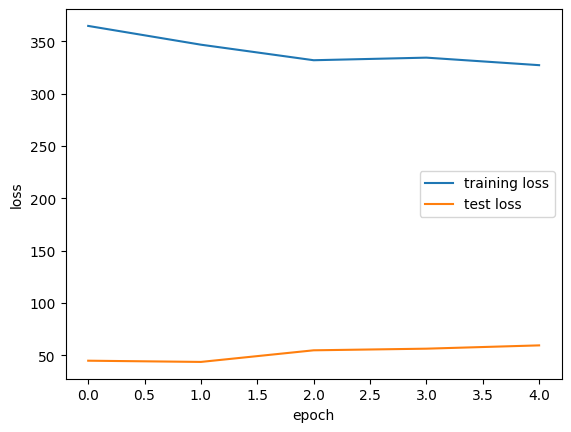

CPU times: user 6.52 s, sys: 865 ms, total: 7.38 s
Wall time: 3.86 s


NeuralNet(
  (fc1): Linear(in_features=20, out_features=20, bias=True)
  (bn1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (hidden_layers): ModuleList(
    (0): Linear(in_features=20, out_features=20, bias=True)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (last_layer): Linear(in_features=20, out_features=1, bias=True)
)

In [8]:
%matplotlib inline
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size, num_hidden=1, hidden_size=50):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.hidden_layers = nn.ModuleList()
        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
            self.hidden_layers.append(nn.BatchNorm1d(hidden_size))
            self.hidden_layers.append(nn.ReLU())
            
        self.last_layer = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu(out)
        for layer in self.hidden_layers:
            out = layer(out)
        out = self.last_layer(out)
        return out
    

def train(X, Y, num_hidden=1, hidden_size=50, lr=1e-2, bs=64, epochs=100):
    train_X = torch.Tensor(X[:int(X.shape[0]*0.7)]).to(device)
    train_Y = torch.Tensor(Y[:int(Y.shape[0]*0.7)]).to(device)

    test_X = torch.Tensor(X[int(X.shape[0]*0.7):]).to(device)
    test_Y = torch.Tensor(Y[int(Y.shape[0]*0.7):]).to(device)
    
    model = NeuralNet(train_X.shape[1], train_Y.shape[1], num_hidden=num_hidden, hidden_size=hidden_size).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  

    loss_list = []
    test_loss = []

    # Train the model
    for epoch in range(epochs):
        for i in range(0, train_X.shape[0], batch_size):
            model.train()
            # Forward pass
            outputs = model(train_X[i:i+batch_size])
            loss = criterion(outputs, train_Y[i:i+batch_size])

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        loss_list.append(loss.item())
        print ('Epoch {}, Loss: {:.4f}'.format(epoch+1, loss.item()))
        
        model.eval()
        test_loss.append(criterion(model(test_X), test_Y).item()) 
    print("\nFINAL TEST LOSS:", test_loss[-1])
        
    plt.plot(loss_list[5:], label="training loss")
    plt.plot(test_loss[5:], label="test loss")
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()
        
    return model
        
from sklearn.datasets import make_regression
x, y = make_regression(n_samples=5000, n_features=20, noise=2, random_state=42)
y = y.reshape(-1, 1)

batch_size = 64

%time train(x, y, num_hidden=2, hidden_size=20, lr=1e-2, epochs=10)

# Embedding type 2 - GIN training using attribute masking on clintox

In [1]:
from torchdrug import data

In [7]:
from rdkit import Chem

In [5]:
from matplotlib import pyplot as plt

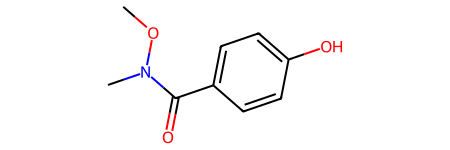

In [8]:
%matplotlib inline
# molecule_from_smile("CON(C)C(=O)c1ccc(O)cc1").visualize()

# plt.show()
Chem.MolFromSmiles("CON(C)C(=O)c1ccc(O)cc1")

In [10]:
from rdkit.Chem import AllChem

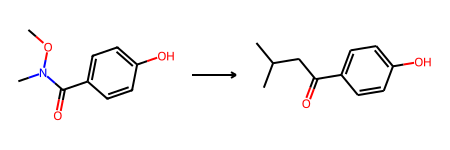

In [17]:
AllChem.ReactionFromSmarts("CON(C)C(=O)c1ccc(O)cc1>>CC(C)CC(=O)c1ccc(O)cc1", useSmiles=True)

In [10]:
model_name = "models/zinc2m_gin.pth"
gin_model = torch.load(model_name).to(device)

In [2]:
def molecule_from_smile(smile):
    try:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain")
    except Exception as e:
        mol = data.Molecule.from_smiles(smile, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
    return mol

def get_mol_embedding(model, smiles):
    # deepchem - attribute masking
    if isinstance(smiles, str):
        mol = molecule_from_smile(smiles)
    else:
        mol = list(map(molecule_from_smile, smiles))
        mol = data.Molecule.pack(mol)
    mol = mol.to(device)
    emb = model(mol, mol.node_feature.float())["graph_feature"]
    return emb.detach().cpu().numpy()

def get_atom_embedding(model, smiles, idx):
    try:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain")
        emb = model(mol, mol.node_feature.float())["node_feature"][idx]
    except Exception as e:
        mol = data.Molecule.from_smiles(smiles, atom_feature="pretrain", bond_feature="pretrain", with_hydrogen=True)
        emb = model(mol, mol.node_feature.float())["node_feature"][idx]
    return emb.detach().cpu()

def get_action_embedding(model, action_df):
    rsub, rcen, rsig, _, psub, pcen, psig, __ = [action_df[c] for c in action_df.columns]
#     print(get_mol_embedding(model, rsub).shape)
#     print(get_atom_embedding(model, rsig, rcen).shape)
#     print(get_mol_embedding(model, rsig).shape)
#     print(get_mol_embedding(model, psub).shape)
#     print(get_atom_embedding(model, psig, pcen).shape)
#     print(get_mol_embedding(model, psig).shape)
    embedding = np.concatenate([
#                         get_mol_embedding(model, rsub), 
#                         get_atom_embedding(model, rsig, rcen) / 5, 
                        get_mol_embedding(model, rsig), 
#                         get_mol_embedding(model, psub), 
#                         get_atom_embedding(model, psig, pcen) / 5, 
                        get_mol_embedding(model, psig)
                    ], axis=1)
    return embedding

In [12]:
batch_size = 64
X = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    reactants = main_df["reactant"][i:i+batch_size]
    products = main_df["product"][i:i+batch_size]
    X.append(np.concatenate([get_mol_embedding(gin_model, reactants), get_mol_embedding(gin_model, products)], axis=1))
X = np.concatenate(X, axis=0)
emb_len = X.shape[1]//2
X.shape

  2%|█▍                                                            | 43/1856 [00:10<06:48,  4.44it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Li`
  warnings.warn("Unknown value `%s`" % x)
 10%|██████▎                                                      | 192/1856 [00:50<06:57,  3.99it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Al`
  warnings.warn("Unknown value `%s`" % x)
 15%|█████████▎                                                   | 285/1856 [01:16<06:05,  4.30it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Ga`
  warnings.warn("Unknown value `%s`" % x)
 24%|██████████████▋                                              | 445/1856 [02:01<07:55,  2.97it/s]/home/abhor/mi

(118744, 256)

In [13]:
batch_size = 64
Y = []
for i in tqdm.tqdm(range(0, main_df.shape[0], batch_size)):
    Y.append(get_action_embedding(gin_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]]))
Y = np.concatenate(Y)
Y.shape

100%|████████████████████████████████████████████████████████████| 1856/1856 [05:50<00:00,  5.30it/s]


(118744, 256)

### MSE training

In [14]:
model = train(X, Y, hidden_size=500, num_hidden=3, lr=1e-3, epochs=100)

Epoch 1, Loss: 0.0486
Epoch 2, Loss: 0.0478
Epoch 3, Loss: 0.0386
Epoch 4, Loss: 0.0305
Epoch 5, Loss: 0.0290
Epoch 6, Loss: 0.0272
Epoch 7, Loss: 0.0259
Epoch 8, Loss: 0.0219
Epoch 9, Loss: 0.0194
Epoch 10, Loss: 0.0183
Epoch 11, Loss: 0.0178
Epoch 12, Loss: 0.0158
Epoch 13, Loss: 0.0169
Epoch 14, Loss: 0.0151
Epoch 15, Loss: 0.0156
Epoch 16, Loss: 0.0144
Epoch 17, Loss: 0.0141
Epoch 18, Loss: 0.0136
Epoch 19, Loss: 0.0130
Epoch 20, Loss: 0.0135
Epoch 21, Loss: 0.0125
Epoch 22, Loss: 0.0128
Epoch 23, Loss: 0.0123
Epoch 24, Loss: 0.0114
Epoch 25, Loss: 0.0124
Epoch 26, Loss: 0.0118
Epoch 27, Loss: 0.0116
Epoch 28, Loss: 0.0114
Epoch 29, Loss: 0.0107
Epoch 30, Loss: 0.0112
Epoch 31, Loss: 0.0103
Epoch 32, Loss: 0.0104
Epoch 33, Loss: 0.0106
Epoch 34, Loss: 0.0098
Epoch 35, Loss: 0.0101
Epoch 36, Loss: 0.0102
Epoch 37, Loss: 0.0097
Epoch 38, Loss: 0.0100
Epoch 39, Loss: 0.0095
Epoch 40, Loss: 0.0097
Epoch 41, Loss: 0.0103
Epoch 42, Loss: 0.0091
Epoch 43, Loss: 0.0089
Epoch 44, Loss: 0.00

In [15]:
torch.save(model, "datasets/my_uspto/supervised_zinc_gin/mse_model.pth")

In [16]:
action_dataset = pd.read_csv("datasets/my_uspto/action_dataset-filtered.csv", index_col=0)
action_dataset = action_dataset.loc[action_dataset["action_tested"] & action_dataset["action_works"]]
action_dataset = action_dataset[["rsub", "rcen", "rsig", "rbond", "psub", "pcen", "psig", "pbond"]]
print(action_dataset.shape)

def get_action_dataset_embeddings(model):
    action_embeddings = []
    for i in tqdm.tqdm(range(0, action_dataset.shape[0], batch_size)):
        action_embeddings.append(get_action_embedding(model, action_dataset.iloc[i:i+batch_size]))
    action_embeddings = np.concatenate(action_embeddings)
    return action_embeddings

action_embeddings = get_action_dataset_embeddings(gin_model)
print(action_embeddings.shape)

(89384, 8)


  7%|████▏                                                         | 94/1397 [00:17<04:02,  5.38it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
 61%|█████████████████████████████████████                        | 849/1397 [02:58<01:57,  4.68it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `As`
  warnings.warn("Unknown value `%s`" % x)
 63%|██████████████████████████████████████▍                      | 881/1397 [03:03<01:27,  5.88it/s]/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/torchdrug-0.2.0-py3.7.egg/torchdrug/data/feature.py:42: UserWarning: Unknown value `Cr`
  warnings.warn("Unknown value `%s`" % x)
 75%|█████████████████████████████████████████████▏              | 1051/1397 [03:38<01:16,  4.52it/s]/home/abhor/min

(89384, 256)


### Back to modeling

In [17]:
# I'm storing as lists, so doing numpy operations for the elements
correct_indices = []
action_embedding_indices = []
for i in tqdm.tqdm(range(main_df.shape[0])):
    row = main_df.iloc[i]
    applicable_actions_df = get_applicable_actions(Chem.MolFromSmiles(row["reactant"]))
    
    indices_used_for_data = np.where(action_dataset.index.isin(applicable_actions_df.index))[0]
    action_embedding_indices.append(indices_used_for_data)

    applicable_actions_df = applicable_actions_df.loc[action_dataset.iloc[indices_used_for_data].index]
    correct_indices.append((applicable_actions_df.index == row.name).argmax())
    
    assert correct_indices[-1] < len(action_embedding_indices[-1]), f"WHAT!? {correct_indices[-1]} vs {len(indices_used_for_data)}"

100%|████████████████████████████████████████████████████████| 118744/118744 [57:16<00:00, 34.55it/s]


In [18]:
def get_ranking(pred, emb_for_comparison, correct_index, distance="euclidean", k=None):
    '''
    Get the rank of the prediction from the applicable actions.
    Returns (rank, [list_of_indices before <rank>])
    '''
    if distance == "euclidean":
        dist = ((emb_for_comparison-pred)**2).sum(axis=1)
    elif distance == "cosine":
        dist = 1 - (emb_for_comparison.dot(pred))/(np.linalg.norm(emb_for_comparison, axis=1)*np.linalg.norm(pred))

    maxy = max(dist)

    list_of_indices = []
    for attempt in range(dist.shape[0]):
        miny = dist.argmin()
#         print(miny, correct_index, dist[correct_index], min(dist), maxy)
        if dist[miny] == dist[correct_index]:
#             print(i, attempt)
            break
        else:
            list_of_indices.append(miny)
            if k is not None and len(list_of_indices) == k:
                return list_of_indices
            dist[miny] = 100000
    
    # When the rank(correct_index) < k, then returns <rank, list>. So this extra condition - add some indices after rank(correct_index) to the list
    if k is not None:
        dist[miny] = 100000
        for attempt in range(min(k, emb_for_comparison.shape[0]-1) - len(list_of_indices)):
            miny = dist.argmin()
            list_of_indices.append(miny)
            dist[miny] = 100000
        return list_of_indices
    return attempt, list_of_indices

def get_top_k_indices(pred, emb_for_comparison, correct_index, distance="euclidean", k=1):
    return get_ranking(pred, emb_for_comparison, correct_index, distance, k)
    
pred = model(torch.Tensor(X[int(main_df.shape[0]*0.8):]).to(device)).detach().cpu().numpy()
l = []
total = []
for i in tqdm.tqdm(range(pred.shape[0])):
    pred_for_i = pred[i]
    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[int(main_df.shape[0]*0.8)+i]], correct_indices[int(main_df.shape[0]*0.8)+i]

    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance="euclidean")
    l.append(rank)
    total.append(act_emb_for_i.shape[0])
print(f"{np.mean(l)}({np.mean(total)}) +- {np.std(l)}  ")


100%|████████████████████████████████████████████████████████| 23749/23749 [00:15<00:00, 1527.85it/s]

44.44010274116805(1341.8814265863825) +- 162.3600825770415  


In [19]:
# https://github.com/mangye16/ReID-Survey
def euclidean_dist(x, y):
    """
    Args:
      x: pytorch Variable, with shape [m, d]
      y: pytorch Variable, with shape [n, d]
    Returns:
      dist: pytorch Variable, with shape [m, n]
    """
    m, n = x.size(0), y.size(0)
    xx = torch.pow(x, 2).sum(1, keepdim=True).expand(m, n)
    yy = torch.pow(y, 2).sum(1, keepdim=True).expand(n, m).t()
    dist = xx + yy
    dist.addmm_(1, -2, x, y.t())
    dist = dist.clamp(min=1e-12).sqrt()  # for numerical stability
    return dist

def cosine_dist(x, y):
    xy = x.matmul(y.t())

    m, n = x.size(0), y.size(0)
    xx = torch.linalg.norm(x, axis=1).expand(n, m).t()
    yy = torch.linalg.norm(y, axis=1).expand(m, n)
    
    return 1 - xy / (xx*yy)


def softmax_weights(dist, mask):
    max_v = torch.max(dist * mask, dim=1, keepdim=True)[0]
    diff = dist - max_v
    Z = torch.sum(torch.exp(diff) * mask, dim=1, keepdim=True) + 1e-6 # avoid division by zero
    W = torch.exp(diff) * mask / Z
    return W

class WeightedRegularizedTriplet(object):
    def __init__(self, dist="euclidean"):
        self.ranking_loss = nn.SoftMarginLoss()
        self.dist = dist

    def __call__(self, global_feat, labels):
        if self.dist=="euclidean":
            dist_mat = euclidean_dist(global_feat, global_feat)
        elif self.dist=="cosine":
            dist_mat = cosine_dist(global_feat, global_feat) ####### NEEEDS TO BE CHANGED!!!!!!!!!!!

        N = dist_mat.size(0)
        # shape [N, N]
        is_pos = labels.expand(N, N).eq(labels.expand(N, N).t()).float()
        is_neg = labels.expand(N, N).ne(labels.expand(N, N).t()).float()

        # `dist_ap` means distance(anchor, positive)
        # both `dist_ap` and `relative_p_inds` with shape [N, 1]
        dist_ap = dist_mat * is_pos
        dist_an = dist_mat * is_neg

        weights_ap = softmax_weights(dist_ap, is_pos)
        weights_an = softmax_weights(-dist_an, is_neg)
        furthest_positive = torch.sum(dist_ap * weights_ap, dim=1)
        closest_negative = torch.sum(dist_an * weights_an, dim=1)

        y = furthest_positive.new().resize_as_(furthest_positive).fill_(1)
        loss = self.ranking_loss(closest_negative - furthest_positive, y)

        return loss

In [20]:
train_idx = np.arange(0, int(main_df.shape[0]*0.8))
test_idx = np.arange(int(main_df.shape[0]*0.8), main_df.shape[0])

In [21]:
%%time
%matplotlib inline
train_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["reactant"]))).to(device)
train_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[train_idx]["product"]))).to(device)

test_reactants = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["reactant"]))).to(device)
test_products = data.Molecule.pack(list(map(molecule_from_smile, main_df.iloc[test_idx]["product"]))).to(device)

CPU times: user 6min 6s, sys: 9.67 s, total: 6min 15s
Wall time: 5min 52s


In [22]:
class PolicyNetwork(nn.Module):
    def __init__(self):
        super(PolicyNetwork, self).__init__()
        self.GIN = torch.load("models/zinc2m_gin.pth")
        self.DENSE = torch.load("datasets/my_uspto/supervised_zinc_gin/mse_model.pth")
    
    def forward(self, x1, x2):
        out1 = self.GIN(x1, x1.node_feature.float())["graph_feature"]
        out2 = self.GIN(x2, x2.node_feature.float())["graph_feature"]
        
        out = torch.concatenate([out1, out2], axis=1)
        out = self.DENSE(out)
        return out

In [23]:
lr = 1e-3
epochs = 50
batch_size = 128

action_embeddings = get_action_dataset_embeddings(gin_model)
# action_embeddings = _action_embeddings.copy()
action_embeddings_norm = np.linalg.norm(action_embeddings)

for distance_metric, negative_method, topk, emb_model_update in itertools.product(["euclidean"], ["all"], [10], [1]):
    print("@"*190)
    print("@"*190)
    print("@"*190)
    
    model = PolicyNetwork().to(device)
    embedding_model = torch.load("models/zinc2m_gin.pth").to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)  
    criterion = WeightedRegularizedTriplet()
    
    metric_dict = {"rank(cosine)": [], "rank(euclidean)": [], "rmse": [], "cos_dist": []}
    # Train the model
    for epoch in range(1, epochs+1):
        model.train()
        for i in range(0, train_reactants.batch_size - batch_size, batch_size):
            # Forward pass
            outputs = model(train_reactants[i:i+batch_size], train_products[i:i+batch_size])

            # Calc negatives
            negatives = []
            
            for _i in range(outputs.shape[0]):
                act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[train_idx[i+_i]]], correct_indices[train_idx[i+_i]]
                curr_out = outputs[_i].detach().cpu().numpy()

                if negative_method == "applicable":
                    top = get_top_k_indices(curr_out, act_emb_for_i, correct_index, distance=distance_metric, k=50)
                    negatives.append(act_emb_for_i[top])
                
                elif negative_method == "all":
                    if distance_metric == "euclidean":
                        dist = np.linalg.norm(action_embeddings - curr_out)
                    elif distance_metric == "cosine":
                        dist = (1 - action_embeddings.dot(curr_out)) / (action_embeddings_norm *np.linalg.norm(curr_out))
                    sorted_idx = np.argsort(dist)[:topk] # get topk
                    sorted_idx = sorted_idx[sorted_idx != correct_index] # Remove if correct index in list
                    negatives.append(action_embeddings[sorted_idx])
                        
            negatives = torch.Tensor(np.concatenate(negatives, axis=0)).to(device)
                                
            # get targets
            targets = torch.Tensor(get_action_embedding(embedding_model, main_df.iloc[i:i+batch_size][main_df.columns[1:-1]])).to(device)
                                
            # Calc loss
            inputs = torch.concat([outputs, targets, negatives])
            labels = torch.concat([torch.arange(outputs.shape[0]), torch.arange(targets.shape[0]), torch.full((negatives.shape[0],), -1)]).to(device)
            loss = criterion(inputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print ('{:.6f}({})'.format(loss.item(), epoch), end='  ')
        
        # SWITCH INDENT HERE ----
        model.eval()
        with torch.no_grad():
            print()

            margin_string = f"# emb_model_update = {emb_model_update} | -ve_method = {negative_method} | dist_metric = {distance_metric} | topk = {topk} #"
            print("#" * len(margin_string))
            print(margin_string)
            print("#" * len(margin_string))

            # Predictions and action component-wise loss
            pred = model(test_reactants, test_products).detach().cpu().numpy() 
            true = get_action_embedding(embedding_model, main_df.iloc[test_idx][main_df.columns[1:-1]])

            metric_df = pd.DataFrame(columns=["rmse", "cos_dist", "rank(euclidean)", "rank(cosine)"])

            # Print Test metrics
            metric_dict["rmse"].append( (((pred-true)**2).sum(axis=1)**0.5).mean() )
            metric_dict["cos_dist"].append( ((pred*true).sum(axis=1) / np.linalg.norm(pred, axis=1) / np.linalg.norm(true, axis=1)).mean() )

            # Print Test metric - Rank
            for dist in ["euclidean", "cosine"]:
                rank_list = []
                l = []
                total = []
                for i in range(pred.shape[0]):
                    pred_for_i = pred[i]
                    act_emb_for_i, correct_index = action_embeddings[action_embedding_indices[test_idx[i]]], correct_indices[test_idx[i]]

                    rank, list_of_indices = get_ranking(pred_for_i, act_emb_for_i, correct_index, distance=dist)
                    l.append(rank)
                    total.append(act_emb_for_i.shape[0])
                rank_list.append(f"{np.mean(l):.4f}({np.mean(total)}) +- {np.std(l):.4f}")
                metric_dict[f"rank({dist})"].append(np.mean(l))

            for col in metric_df.columns:
                metric_df[col] = [metric_dict[col][-1]]
            metric_df.index = [epoch]
            print(tabulate(metric_df, headers='keys', tablefmt='fancy_grid'))
            print()
            
        # Update embedding model and action_embeddings
        if epoch % emb_model_update == 0:
            embedding_model.load_state_dict(model.GIN.state_dict())
            action_embeddings = get_action_dataset_embeddings(embedding_model)
            action_embeddings_norm = np.linalg.norm(action_embeddings)
            
    fig = plt.figure(figsize=(8, 8))
    for dist in filter(lambda x: "rank" in x, metric_dict.keys()):
        plt.plot(metric_dict[dist], label=dist)
    plt.title(distance_metric)
    plt.xlabel("epoch")
    plt.ylabel("ranking")
    plt.legend()
    fig.show()
    
    # save everything
    folder = f"models/supervised/2step/emb_model_update={emb_model_update}||-ve_method={negative_method}||dist_metric={distance_metric}||topk={topk}"
    os.makedirs(folder, exist_ok = True)
    torch.save(model, os.path.join(folder, "model.pth"))
    pd.DataFrame.from_dict(metric_dict).to_csv(os.path.join(folder, "metrics.csv"))
    fig.savefig(os.path.join(folder, "plot.png"))
    json.dump({
        "lr": lr,
        "epochs": epochs, 
        "batch_size": batch_size,
        "train_samples": train_idx.shape,
        "test_samples": test_idx.shape,
        "distance_metric": distance_metric,
        "negative_method": negative_method,
        "topk": topk,
        "emb_model_update": emb_model_update,
    }, open(os.path.join(folder, "config.txt"), 'w'))

100%|██████████████████████████████████████████████████████████████| 699/699 [03:59<00:00,  2.92it/s]


@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


/home/abhor/miniconda3/envs/de_novo/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at /opt/conda/conda-bld/pytorch_1670525541035/work/torch/csrc/utils/python_arg_parser.cpp:1420.)
  


0.065111(1)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  1 │ 2.21291 │   0.937667 │           40.1599 │        32.7022 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:55<00:00,  2.97it/s]


0.050618(2)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  2 │ 2.16196 │   0.943942 │           28.5987 │        23.3654 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:55<00:00,  2.97it/s]


0.033292(3)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤════════════╤═══════════════════╤════════════════╕
│    │   rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪════════╪════════════╪═══════════════════╪════════════════╡
│  3 │ 1.9741 │   0.952626 │           22.2586 │        16.8621 │
╘════╧════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:02<00:00,  2.88it/s]


0.029329(4)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  4 │ 1.90997 │   0.955929 │           21.8402 │        16.8918 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:54<00:00,  2.99it/s]


0.030627(5)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤════════════╤═══════════════════╤════════════════╕
│    │   rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪════════╪════════════╪═══════════════════╪════════════════╡
│  5 │ 1.8698 │   0.958127 │           21.0913 │        15.8425 │
╘════╧════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:51<00:00,  3.02it/s]


0.030970(6)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  6 │ 1.83188 │   0.959969 │           18.8967 │         14.315 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:08<00:00,  2.27it/s]


0.043086(7)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  7 │ 2.21358 │   0.943071 │           28.1425 │        21.3724 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:51<00:00,  3.02it/s]


0.038998(8)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  8 │ 1.86557 │   0.959561 │           21.7157 │        15.8386 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:03<00:00,  2.87it/s]


0.025866(9)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│  9 │ 1.77566 │   0.963747 │            18.768 │        13.0727 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:49<00:00,  3.05it/s]


0.024856(10)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 10 │ 1.75477 │   0.964888 │           17.4388 │        12.2671 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:49<00:00,  3.05it/s]


0.028710(11)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 11 │ 1.80687 │   0.963753 │           18.3718 │        12.7041 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:21<00:00,  2.67it/s]


0.025753(12)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 12 │ 1.80734 │   0.963071 │           18.5538 │        12.7438 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:44<00:00,  2.46it/s]


0.027397(13)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 13 │ 1.78745 │   0.965118 │           17.4631 │        12.2756 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:54<00:00,  2.98it/s]


0.022636(14)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 14 │ 1.71882 │   0.967495 │           15.8187 │         10.801 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:48<00:00,  3.05it/s]


0.023390(15)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 15 │ 1.73088 │   0.967366 │           15.4832 │        10.3821 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:49<00:00,  3.05it/s]


0.024162(16)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤════════════╤═══════════════════╤════════════════╕
│    │   rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪════════╪════════════╪═══════════════════╪════════════════╡
│ 16 │ 1.7602 │   0.965897 │           16.3387 │        11.0701 │
╘════╧════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:51<00:00,  3.02it/s]


0.023763(17)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 17 │ 1.73368 │   0.967469 │            15.143 │         9.2246 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:54<00:00,  2.97it/s]


0.023066(18)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 18 │ 1.72015 │   0.968467 │           15.4468 │        10.3111 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:57<00:00,  2.94it/s]


0.022067(19)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 19 │ 1.69611 │   0.969463 │           14.6916 │        9.40431 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:48<00:00,  3.06it/s]


0.020971(20)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 20 │ 1.68373 │   0.969808 │           14.4089 │        8.92737 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:56<00:00,  2.95it/s]


0.030163(21)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 21 │ 1.83006 │   0.965206 │           16.1422 │          10.18 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:52<00:00,  3.01it/s]


0.022872(22)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 22 │ 1.77517 │   0.967905 │           13.6412 │         7.5932 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:50<00:00,  3.04it/s]


0.020692(23)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 23 │ 1.71408 │   0.969752 │           13.3606 │        7.92362 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:05<00:00,  2.84it/s]


0.021594(24)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤════════════╤═══════════════════╤════════════════╕
│    │   rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪════════╪════════════╪═══════════════════╪════════════════╡
│ 24 │ 1.7157 │   0.969698 │           13.4592 │        7.61236 │
╘════╧════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:53<00:00,  2.99it/s]


0.021061(25)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 25 │ 1.72816 │   0.969253 │           13.2689 │        7.76311 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:48<00:00,  3.06it/s]


0.033229(26)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤════════════╤═══════════════════╤════════════════╕
│    │   rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪════════╪════════════╪═══════════════════╪════════════════╡
│ 26 │ 2.0028 │   0.959948 │           15.9269 │        8.96025 │
╘════╧════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:17<00:00,  2.71it/s]


0.027766(27)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 27 │ 1.89792 │   0.964767 │           15.3318 │        9.63059 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:50<00:00,  3.04it/s]


0.022937(28)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 28 │ 1.73273 │   0.970006 │           13.9522 │        9.21264 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:01<00:00,  2.89it/s]


0.021013(29)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 29 │ 1.67829 │   0.971377 │           13.0842 │        8.20814 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:21<00:00,  2.67it/s]


0.020861(30)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 30 │ 1.66483 │   0.971654 │            12.422 │        7.43779 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:53<00:00,  3.00it/s]


0.021181(31)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 31 │ 1.66816 │   0.971723 │           12.7596 │        7.43939 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:48<00:00,  3.06it/s]


0.038708(32)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 32 │ 2.07459 │   0.957135 │           15.9384 │        9.77346 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:03<00:00,  2.30it/s]


0.032196(33)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 33 │ 1.85349 │   0.965412 │           18.2649 │        11.9128 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:53<00:00,  2.99it/s]


0.025889(34)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 34 │ 1.73266 │   0.969705 │           13.7246 │        9.60988 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:46<00:00,  3.08it/s]


0.024155(35)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 35 │ 1.68109 │   0.971479 │           13.7912 │        9.54188 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:12<00:00,  2.24it/s]


0.023296(36)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤════════╤════════════╤═══════════════════╤════════════════╕
│    │   rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪════════╪════════════╪═══════════════════╪════════════════╡
│ 36 │ 1.6721 │   0.971772 │           13.3243 │        8.97225 │
╘════╧════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [04:39<00:00,  2.50it/s]


0.023389(37)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 37 │ 1.68172 │   0.971564 │           13.1344 │        8.62588 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:48<00:00,  3.06it/s]


0.022593(38)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 38 │ 1.69548 │   0.971474 │           12.4198 │        7.61965 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:54<00:00,  2.99it/s]


0.022254(39)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 39 │ 1.71137 │   0.970928 │           14.1534 │        9.40385 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [05:08<00:00,  2.26it/s]


0.022476(40)  
#################################################################################
# emb_model_update = 1 | -ve_method = all | dist_metric = euclidean | topk = 10 #
#################################################################################
╒════╤═════════╤════════════╤═══════════════════╤════════════════╕
│    │    rmse │   cos_dist │   rank(euclidean) │   rank(cosine) │
╞════╪═════════╪════════════╪═══════════════════╪════════════════╡
│ 40 │ 1.70571 │   0.970876 │            13.325 │        8.90214 │
╘════╧═════════╧════════════╧═══════════════════╧════════════════╛



100%|██████████████████████████████████████████████████████████████| 699/699 [03:53<00:00,  3.00it/s]


KeyboardInterrupt: 